In [1]:
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda, Conv2D, Conv2DTranspose, Activation, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

from util import plotScatterDecode, plotProgress, plotCompDecode, plotScatterEncode, addNoise

Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 100
sizeBatch = 32
sizeKernel = 3
dimInter = 128
dimEncode = 32
layer_filters = [8, 16, 32, 64]
stdEps = 1.0 
ratRecon = 0.998
factNoise = 0
nameOptim = 'adam'

## Load the datasets

In [3]:
(xTrain, _), (xTest, yTest) = cifar10.load_data()
yTest = np.squeeze(yTest, axis=1)
sizeDigit = xTrain.shape[1]
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = xTrain.shape[1:]

xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
xTrain

xTrain = np.reshape(xTrain, [-1, *dimInput])
xTest = np.reshape(xTest, [-1, *dimInput])
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Construct the encoder and decoder

In [4]:
inputs = Input(shape=(dimInput))  # adapt this if using `channels_first` image data format
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=sizeKernel,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
x = Dense(dimInter, activation='relu')(x)
zMean = Dense(dimEncode)(x)
zSigmaLog = Dense(dimEncode)(x) # log for linear dense

def sampling(args):
    zMean, zSigmaLog = args
    epsilon = K.random_normal(shape=(K.shape(zMean)[0], dimEncode),
                              mean=0., stddev=stdEps)
    return zMean + K.exp(zSigmaLog) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Lambda(sampling)([zMean, zSigmaLog])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

# Build the Decoder Model
inputLatent = Input(shape=(dimEncode,), name='decoder_input')
x = Dense(dimInter, activation='relu')(inputLatent)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=sizeKernel,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=3,
                    kernel_size=sizeKernel,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(inputLatent, outputs, name='decoder')
decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 8)    224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 16)     1168        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 4, 4, 32)     4640        conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

## Construct the autoencoder

In [5]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 32)                65680     
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         98643     
Total params: 164,323
Trainable params: 164,323
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
def lossVAE(zMean, zSigmaLog):
    def loss(tensorInput, tensorDecode):
        lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
        lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    return loss

autoencoder.compile(optimizer=nameOptim, loss=lossVAE(zMean, zSigmaLog))

# Train the autoencoder
tic = time()
history = autoencoder.fit(xTrainNoise, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 30s 601us/step - loss: 0.6464 - val_loss: 0.6366
Epoch 2/100
50000/50000 [==============================] - 28s 551us/step - loss: 0.6345 - val_loss: 0.6340
Epoch 3/100
50000/50000 [==============================] - 27s 533us/step - loss: 0.6323 - val_loss: 0.6319
Epoch 4/100
50000/50000 [==============================] - 26s 530us/step - loss: 0.6309 - val_loss: 0.6313
Epoch 5/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.6296 - val_loss: 0.6296
Epoch 6/100
50000/50000 [==============================] - 27s 538us/step - loss: 0.6287 - val_loss: 0.6294
Epoch 7/100
50000/50000 [==============================] - 26s 529us/step - loss: 0.6282 - val_loss: 0.6283
Epoch 8/100
50000/50000 [==============================] - 27s 532us/step - loss: 0.6274 - val_loss: 0.6279
Epoch 9/100
50000/50000 [==============================] - 26s 528us/step - loss: 0.62

Epoch 76/100
50000/50000 [==============================] - 20s 408us/step - loss: 0.6236 - val_loss: 0.6250
Epoch 77/100
50000/50000 [==============================] - 21s 415us/step - loss: 0.6237 - val_loss: 0.6249
Epoch 78/100
50000/50000 [==============================] - 21s 417us/step - loss: 0.6236 - val_loss: 0.6248
Epoch 79/100
50000/50000 [==============================] - 21s 427us/step - loss: 0.6237 - val_loss: 0.6250
Epoch 80/100
50000/50000 [==============================] - 20s 403us/step - loss: 0.6237 - val_loss: 0.6247
Epoch 81/100
50000/50000 [==============================] - 21s 411us/step - loss: 0.6236 - val_loss: 0.6251
Epoch 82/100
50000/50000 [==============================] - 21s 415us/step - loss: 0.6237 - val_loss: 0.6249
Epoch 83/100
50000/50000 [==============================] - 21s 412us/step - loss: 0.6236 - val_loss: 0.6249
Epoch 84/100
50000/50000 [==============================] - 21s 413us/step - loss: 0.6236 - val_loss: 0.6248
Epoch 85/100
50000/

## Show the historical training progress 

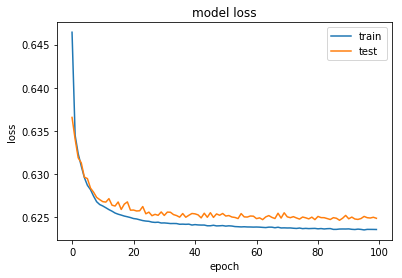

In [7]:
# print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTestNoise)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

In [9]:
plotCompDecode(xTest, decodeTest, sizeReshape = (32, 32, 3))

TypeError: plotCompDecode() got an unexpected keyword argument 'sizeReshape'

## Plot the scatter of the encoding space

In [ ]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

In [ ]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (32,32,3), xlim, ylim)

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

In [ ]:
(xTrain, _), (xTest, yTest) = mnist.load_data()

In [ ]:
xTest.shape

In [10]:
[-1, *dimInput]

[-1, 32, 32, 3]